# Automatic-counting-of-epidermal-cells-with-Deep-Learning

## Librerias

In [1]:
from detectron2.utils.logger import setup_logger
logger = setup_logger()
from detectron2.data.datasets import register_coco_instances

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import CfgNode as CN

from tqdm import tqdm
import os
import torch
from torch.utils.data import Dataset, DataLoader
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pickle
import matplotlib.pyplot as plt
import random
import cv2
import torch

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

## Configuración de un conjunto de datos para su uso en el framework Detectron2

In [3]:
# Some configurations
name_ds = "dataset"
name_ds_train = name_ds + "_train"
name_ds_val = name_ds + "_val"
name_ds_test = name_ds + "_test"
image_root_train = name_ds + "/train"
image_root_validation = name_ds + "/validation"
image_root_test = name_ds + "/test"

json_file_train = name_ds + "/train/" + 'coco_annotation_train.json'
json_file_val = name_ds + "/validation/" + 'coco_annotation_validation.json'
json_file_test = name_ds + "/test/" + 'coco_annotation_test.json'

# Register datasets
## train dataset
register_coco_instances(
    name = name_ds_train,
    metadata = {},
    json_file = json_file_train,
    image_root = image_root_train
    )

## validation dataset
register_coco_instances(
    name = name_ds_val,
    metadata = {},
    json_file = json_file_val,
    image_root = image_root_validation
    )

## test dataset
register_coco_instances(
    name = name_ds_test,
    metadata = {},
    json_file = json_file_test,
    image_root = image_root_test
    )


In [4]:
train_metadata = MetadataCatalog.get(name_ds_train)
train_dataset_dicts = DatasetCatalog.get(name_ds_train)

[11/19 09:01:04 d2.data.datasets.coco]: Loaded 54 images in COCO format from dataset/train/coco_annotation_train.json


In [5]:
val_metadata = MetadataCatalog.get(name_ds_val)
val_dataset_dicts = DatasetCatalog.get(name_ds_val)

[11/19 09:01:04 d2.data.datasets.coco]: Loaded 6 images in COCO format from dataset/validation/coco_annotation_validation.json


In [6]:
test_metadata = MetadataCatalog.get(name_ds_test)
test_dataset_dicts = DatasetCatalog.get(name_ds_test)

[11/19 09:01:04 d2.data.datasets.coco]: Loaded 8 images in COCO format from dataset/test/coco_annotation_test.json


### Visualizar ejemplo

In [ ]:
for d in random.sample(train_dataset_dicts,2):
    img = cv2.imread(d['file_name'])
    visualizer = Visualizer(img[:,:,::-1], metadata= train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:,:,::-1])
    plt.show()

## Setting anchor sizes,anchor ratios and model

In [ ]:
# Basic Option

#config_file_url = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
#checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"     


In [ ]:
# Output directory
output_dir = "ResultadosEntrenamiento"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")

# Number of classes
nc = 3

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Select a larger model
config_file_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"


https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Crear una configuración
cfg = get_cfg()

# Configurar el archivo de configuración del modelo y los pesos
config_file_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)

# Configurar el conjunto de datos de entrenamiento
cfg.DATASETS.TRAIN = (name_ds_train,)

# Configurar el número de trabajadores de carga de datos
cfg.DATALOADER.NUM_WORKERS = 2

# Configurar el número de imágenes por lote (batch size)
cfg.SOLVER.IMS_PER_BATCH = 4  # Puedes ajustar este valor según la capacidad de tu GPU

# Configurar la tasa de aprendizaje
cfg.SOLVER.BASE_LR = 0.00025

# Configurar el número máximo de iteraciones (epochs)
cfg.SOLVER.MAX_ITER = 5000

# Configurar el período para ajustar la tasa de aprendizaje
cfg.SOLVER.STEPS = (1000, 2000, 3000, 4000)  # Puedes ajustar estos valores según tu preferencia
cfg.SOLVER.GAMMA = 0.1  # Factor de reducción de la tasa de aprendizaje en cada paso

# Configurar el período para guardar puntos de control durante el entrenamiento
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

# Configurar el período para la evaluación durante el entrenamiento
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD

# Configurar el número de clases
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc

# Configurar el dispositivo de entrenamiento
cfg.MODEL.DEVICE = device

# Configurar el directorio de salida
cfg.OUTPUT_DIR = output_dir


### Trainer

In [ ]:
trainer = DefaultTrainer(cfg)

### AnchorCalculator, anchorSizeRatioTuner

In [ ]:
print("MIN_SIZE_TRAIN", cfg.INPUT.MIN_SIZE_TRAIN)
print("MAX_SIZE_TRAIN", cfg.INPUT.MAX_SIZE_TRAIN)

In [ ]:
from hyperparameter_tuning import AnchorCalculator, anchorSizeRatioTuner

anchorcalcualtor = AnchorCalculator(trainer,cfg)

data = anchorcalcualtor.data
for i in data:
  print(i['image'].shape)


In [ ]:
images = trainer.model.preprocess_image(data)
print(images.tensor.shape)

In [ ]:
anchorcalcualtor.visualize_images_gt_box()

In [ ]:
gt_boxes = anchorcalcualtor.get_gt_boxes(1000)
print()
print(gt_boxes.shape)

In [ ]:
gt_wh = anchorcalcualtor.boxes2wh()
print(gt_wh.min(), gt_wh.max())

In [ ]:
print("sizes", cfg.MODEL.ANCHOR_GENERATOR.SIZES)
print("ratios", cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS)

In [ ]:
print("recall", anchorcalcualtor.best_recall())
print("fitness", anchorcalcualtor.fitness())

#### Using clstering

In [ ]:
gt_sizes = anchorcalcualtor.wh2size()
gt_ratios = anchorcalcualtor.wh2ratio()

In [ ]:
anchorTuner = anchorSizeRatioTuner(trainer, fit_fn = anchorcalcualtor.fitness)

In [ ]:
sizes = anchorTuner.estimate_clusters(gt_sizes, 5)
anchorTuner.visualize_clusters(gt_sizes, sizes)
ratios = anchorTuner.estimate_clusters(gt_ratios, 3)
anchorTuner.visualize_clusters(gt_ratios, ratios)

In [ ]:
anchors = trainer.model.proposal_generator.anchor_generator.generate_cell_anchors
anchors = anchors(sizes, ratios)

In [ ]:
anchorcalcualtor.fitness(anchors = anchors)

In [ ]:
print("sizes", sizes)
print("ratios", ratios)

### Evolve the results using the genetic algorithm

In [ ]:
e_sizes, e_ratios = anchorTuner.evolve(sizes, ratios)

In [ ]:
anchorTuner.visualize_clusters(gt_sizes, e_sizes)
anchorTuner.visualize_clusters(gt_ratios, e_ratios)

In [ ]:
print("sizes", e_sizes)
print("ratios", e_ratios)

### Pixel means and Standar deviations

In [ ]:
#!pip install albumentations

In [ ]:
from hyperparameter_tuning import ImagesMeanStd
from dataset_utils import DatasetWithTransform
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json

#### Batch

In [ ]:
batch_size = 32
num_workers = 2
image_size = 800
augs = A.Compose([
    A.Resize(height = image_size, width = image_size),
    ToTensorV2()])

In [ ]:
with open(json_file_train) as f:
  ds = json.load(f)['images']

tds = DatasetWithTransform(ds, img_dir=image_root_train, transform=augs)
image_loader = DataLoader(tds, 
                          batch_size  = batch_size, 
                          shuffle     = False, 
                          num_workers = num_workers,
                          pin_memory  = True)

### Obtain pixels mean and std

In [ ]:
ims = ImagesMeanStd()

for inputs in tqdm(image_loader):
    ims.push(inputs)

In [ ]:
print(ims.mean)
print(ims.std)

## Train configuration

In [7]:
# Output directory
output_dir = "ResultadosEntrenamientoModel"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")

# Number of classes
nc = 3

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Select a larger model



config_file_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

config_file_url = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"


# cgf

In [8]:
cfg = get_cfg()
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)

cfg.DATASETS.TRAIN = (name_ds_train,)
cfg.DATASETS.TEST = (name_ds_val,)

cfg.DATALOADER.NUM_WORKERS = 5

cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.STEPS = (1000, 3000)
cfg.SOLVER.MAX_ITER = 8000
cfg.SOLVER.WARMUP_ITERS = 600
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.NESTROV = False

cfg.SOLVER.CHECKPOINT_PERIOD = 2000

cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[235.22549476], [179.05405228], [139.30770719], [103.55499222], [370.6310331]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[1.10595414, 0.71510455, 1.61066097]]

cfg.MODEL.PIXEL_MEAN = [141.4449, 141.4449, 141.4449]
cfg.MODEL.PIXEL_STD = [34.6302, 34.6302, 34.6302]

cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc

cfg.MODEL.DEVICE = device
cfg.OUTPUT_DIR = output_dir

In [9]:
# save configuration file for future use
with open(output_cfg_path, "wb") as f:
  pickle.dump(cfg, f, protocol = pickle.HIGHEST_PROTOCOL)

# Train()

In [10]:
import gc
gc.collect()

123

In [11]:
from model import *

trainer = EagleNestAugTrainer(cfg)

bm_hook = BestModelHook(cfg, metric  = "segm/AP50", min_max = "max")
trainer.register_hooks(hooks=[bm_hook])

[11/19 09:02:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [12]:
#trainer = DefaultTrainer(cfg)

In [13]:
trainer.train()

[11/19 09:02:56 d2.engine.train_loop]: Starting training from iteration 0
[11/19 09:03:04 d2.utils.events]:  eta: 0:35:18  iter: 19  total_loss: 5.318  loss_cls: 2.434  loss_box_reg: 0.5305  loss_mask: 0.5027  loss_rpn_cls: 0.7544  loss_rpn_loc: 1.339    time: 0.2662  last_time: 0.2877  data_time: 0.0235  last_data_time: 0.0053   lr: 3.2635e-05  max_mem: 1769M


2023-11-19 09:03:04.230624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 09:03:04.891411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[11/19 09:03:11 d2.utils.events]:  eta: 0:34:57  iter: 39  total_loss: 2.697  loss_cls: 0.7489  loss_box_reg: 0.649  loss_mask: 0.3233  loss_rpn_cls: 0.6545  loss_rpn_loc: 0.3243    time: 0.2761  last_time: 0.2816  data_time: 0.0049  last_data_time: 0.0036   lr: 6.5935e-05  max_mem: 1769M
[11/19 09:03:16 d2.utils.events]:  eta: 0:34:52  iter: 59  total_loss: 2.482  loss_cls: 0.6164  loss_box_reg: 0.5919  loss_mask: 0.3035  loss_rpn_cls: 0.6321  loss_rpn_loc: 0.2391    time: 0.2713  last_time: 0.2760  data_time: 0.0050  last_data_time: 0.0055   lr: 9.9235e-05  max_mem: 1769M
[11/19 09:03:21 d2.utils.events]:  eta: 0:34:23  iter: 79  total_loss: 2.231  loss_cls: 0.5017  loss_box_reg: 0.4421  loss_mask: 0.3886  loss_rpn_cls: 0.6493  loss_rpn_loc: 0.2144    time: 0.2663  last_time: 0.2527  data_time: 0.0042  last_data_time: 0.0047   lr: 0.00013254  max_mem: 1769M
[11/19 09:03:26 d2.utils.events]:  eta: 0:34:05  iter: 99  total_loss: 2.302  loss_cls: 0.5381  loss_box_reg: 0.5272  loss_mask:

## Keep best model

In [14]:
from glob import glob
files = glob(os.path.join(cfg.OUTPUT_DIR, "*.pth"))
for f in files:
    if f != os.path.join(cfg.OUTPUT_DIR, "model_best.pth"):
        os.remove(f)

# GPU

In [15]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST  = 0.6
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 
                                 "model_best.pth")
predictor = DefaultPredictor(cfg)

[11/19 09:38:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ResultadosEntrenamientoModel/model_best.pth ...


[11/19 09:38:25 d2.data.datasets.coco]: Loaded 8 images in COCO format from dataset/test/coco_annotation_test.json


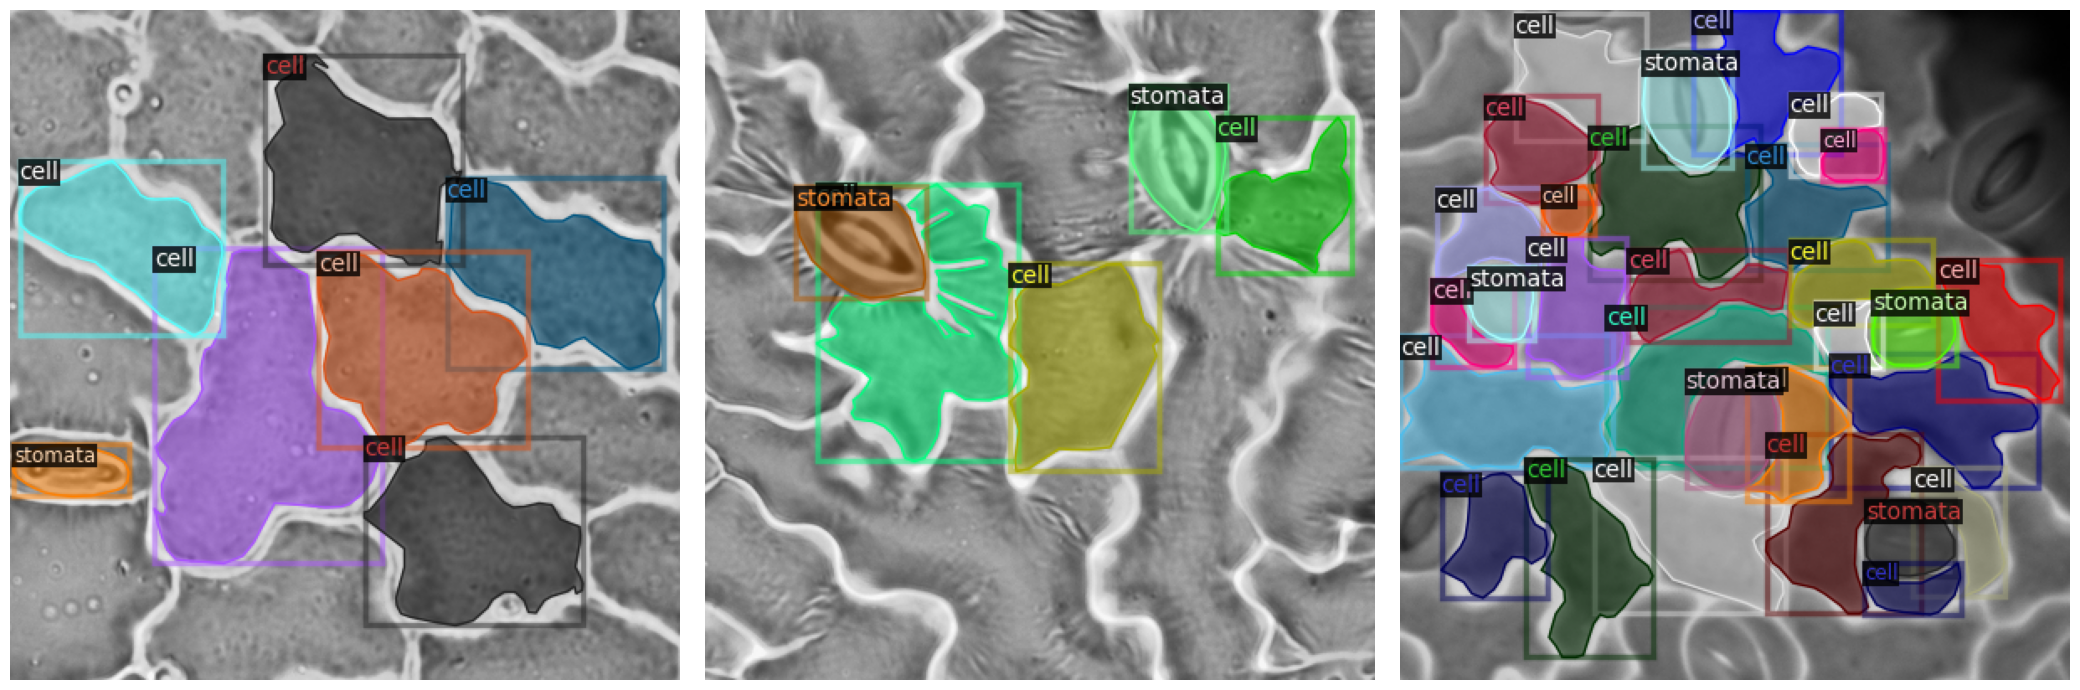

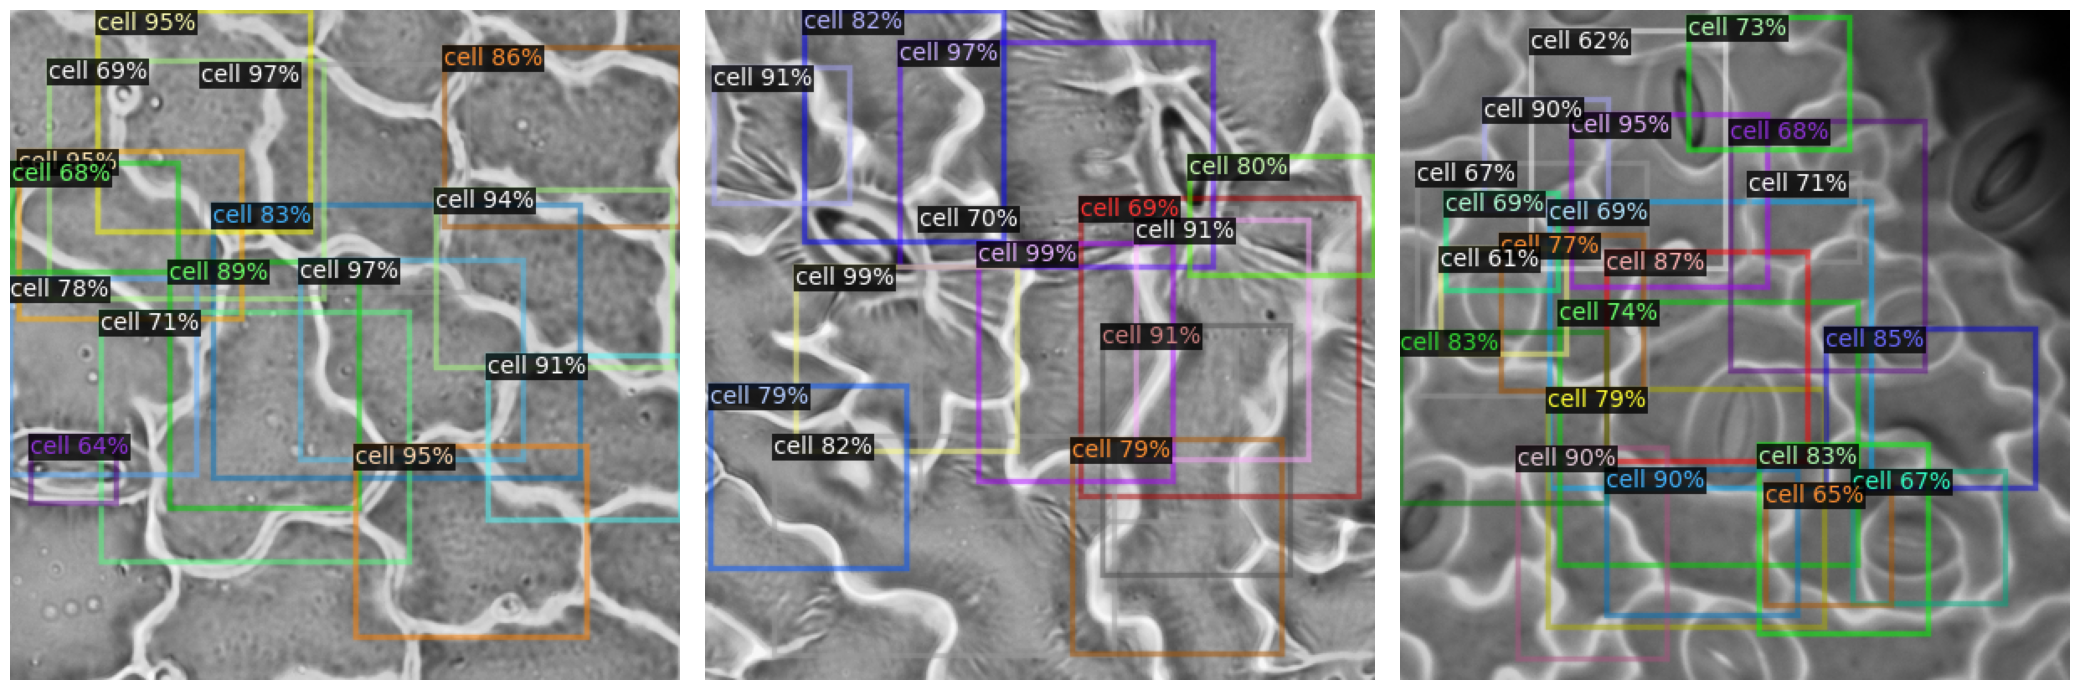

In [16]:
from viz_prediction import plot_random_samples

plot_random_samples(name_ds_test, predictor = predictor)

In [ ]:
# Después del entrenamiento
model_path = "./2MODEL3500.pth"
torch.save(trainer.model.state_dict(), model_path)

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST  = 0.6
cfg.MODEL.WEIGHTS = "./3MODEL3500.pth"

predictor = DefaultPredictor(cfg)

In [ ]:
from viz_prediction import plot_random_samples
plot_random_samples(name_ds_test, predictor = predictor)

In [ ]:
torch.cuda.empty_cache()